# CNN Image Recognition Architecture Implementation


In [1]:
#GETTING THE CIFAR DATASET READY FOR EXPERIMENTATION
import tensorflow_datasets as tfds
import tensorflow as     tf
import math
import numpy             as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *

In [2]:
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10

# model
MODEL_LEVEL_0_BLOCKS    = 4
MODEL_LEVEL_1_BLOCKS    = 4
MODEL_LEVEL_2_BLOCKS    = 5
BLOCK_REPEATS = [MODEL_LEVEL_0_BLOCKS,MODEL_LEVEL_1_BLOCKS,MODEL_LEVEL_2_BLOCKS]

# training
TRAINING_BATCH_SIZE      = 128
TRAINING_SHUFFLE_BUFFER  = 5000
TRAINING_BN_MOMENTUM     = 0.9
TRAINING_BN_EPSILON      = 0.001

TRAINING_LR_MAX          = 0.001
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 25

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = 'F://Models/Model_Design/'


######################################################################
# TRAINING FUNCTIONS FOR THE CIFAR DATASET
######################################################################
def pre_processing_train(example):
    image = example["image"]
    label = example["label"]
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    return image, label

def pre_processing_test(example):
    image = example["image"]
    label = example["label"]
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    return image, label

# learning rate schedule
def lr_schedule(epoch):
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL
    return lr

def plot_training_curves(history):
    # training and validation data accuracy
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


def train(MODEL, model_name, logs=False):
    """
    Inputs:
    MODEL: tf.keras.Model - used for training
    model_name: string - name of the trained model
    logs: Bool - whether to print logs for each training epoch
    
    Trains MODEL for TRAINING_NUM_EPOCHS epochs, saving best model at 
    each epoch. Plots the training curve and evaluates the final model on
    the validation dataset.
    
    """
    print("######################################################")
    print(model_name)
    print("######################################################")
    
    callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_schedule),
                 tf.keras.callbacks.ModelCheckpoint(filepath=str(SAVE_MODEL_PATH)+model_name+'/', 
                                                    save_best_only=True, 
                                                    period=10,
                                                    monitor='val_loss', 
                                                    verbose=0)]
    # training
    initial_epoch_num = 0
    print("Training model {}...".format(model_name))
    history  = MODEL.fit(x=dataset_train, 
                          epochs=TRAINING_NUM_EPOCHS, 
                          verbose=logs, 
                          callbacks=callbacks, 
                          validation_data=dataset_test,                               
                          initial_epoch=initial_epoch_num)

    print("Training complete.")
    return history

def benchmark(MODEL, history, model_name):
    # plot accuracy and loss curves
    plot_training_curves(history)
    # test
    test_loss, test_accuracy = MODEL.evaluate(x=dataset_test)
    print('Test loss:     ', test_loss)
    print('Test accuracy: ', test_accuracy)

In [3]:
#PREPARE THE CIFAR DATASET
# download data and split into training and testing datasets
dataset_train, info = tfds.load("cifar10", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("cifar10", split=tfds.Split.TEST,  with_info=True)

dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=4)
dataset_train = dataset_train.shuffle(buffer_size=TRAINING_SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=3)

# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=4)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=3)

## CNN Architecture Utilities

In [4]:
conv_params = {"padding":'same',
              "use_bias":False,
              "activation":None}

bn_params = {"axis":-1,
             "momentum":TRAINING_BN_MOMENTUM, 
             "epsilon":TRAINING_BN_EPSILON, 
             "center":True, 
             "scale":True}

def conv_block(inputs, filters, kernel_size=(3,3), strides=(1,1)):
    """Generic Conv -> BN -> ReLU abstraction"""
    x = Conv2D(filters, kernel_size, strides=strides, **conv_params)(inputs)
    x = BatchNormalization(**bn_params)(x)
    x = ReLU()(x)
    return x  

def VGG_Like_CNN(tail_function, block_function, head_function, input_shape=None, num_levels=None, block_repeats=None, start_dims=32):
    """
    INPUTS:
    tail_function: function(in_tensor, dims, **kwargs) -> out tensor
    block_function: function(in_tensor, dims, downsampling=Bool, **kwargs) -> out tensor
    head_function: function(in_tensor, dims=None, **kwargs) -> out tensor
    input_shape: tuple- input shape of the network ex. (15,) or (3,32,32)
    num_levels: int - number of levels in the VGG-like architecture
    block_repeats: list - number of block repeats for each level of VGG-like architecture
    start_dims: int - number of filters to be given to the head block. will double each level
    """
    model_input = Input(shape=input_shape)
    dims = int(start_dims)
    
    #TAIL
    x = tail_function(model_input, dims)
    
    #BODY
    for level in range(num_levels):
        for block in range(block_repeats[level]):
            x = block_function(x, dims)
        dims = int(dims*2)
        x = block_function(x, dims, downsample=True)
        
    #HEAD
    model_output = head_function(x, dims=dims)
    return tf.keras.Model(inputs=model_input, outputs=model_output)

## ResNet Architecture

### Sources 
- [1](https://arxiv.org/pdf/1611.05431.pdf)
- [2](https://arxiv.org/pdf/1512.03385.pdf)
- [3](https://arxiv.org/pdf/1603.05027.pdf)

### Notes
[ResNet V1 Paper](https://arxiv.org/pdf/1512.03385.pdf)

__Intuition behind Residual Connenction__

*The degradation (of training accuracy) indicates that not
all systems are similarly easy to optimize... There exists a solution by construction
to the deeper model: the added layers are identity mapping,
and the other layers are copied from the learned shallower
model. The existence of this constructed solution indicates
that a deeper model should produce no higher training error
than its shallower counterpart.*

*or unable to do so in feasible time).
In this paper, we address the degradation problem by
introducing a deep residual learning framework.... we let the stacked nonlinear
layers fit another mapping of F(x) := H(x)−x. The original mapping is recast into F(x)+x. We hypothesize that it
is easier to optimize the residual mapping than to optimize
the original, unreferenced mapping. To the extreme, if an
identity mapping were optimal, it would be easier to push
the residual to zero than to fit an identity mapping by a stack
of nonlinear layers.*

*. With the residual learning reformulation, if identity mappings are optimal, the solvers
may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings.*
VGG style architecture with bottleneck "residual blocks" that allow propagation of gradients cleanly anywhere in the network. Allows the training of arbitratily deep networks by allowing the network to easily map a layer to an *identity function*, zeroeing out the parameters of network layers that do not improve performance.

More Notes: 
- For downsampling blocks where the shape of the input is changed, the "identity path" must go through a 1x1 Conv layer w/ stride 2 and no activation.
- Activation and batch norm are best applied __before__ the convolution operation (within the residual path).

__What to do during down sampling__

*The dimensions of x and F must be equal in Eqn.(1).
If this is not the case (e.g., when changing the input/output
channels), we can perform a __linear projection Ws__ by the
shortcut connections to match the dimensions:
y = F(x, {Wi}) + Wsx.*

*The identity shortcuts (Eqn.(1)) can be directly used when the input and utput are of the same dimensions (solid line shortcuts in ig. 3). When the dimensions increase (dotted line shortcuts in Fig. 3), we consider two options: (A) The shortcut still performs identity mapping, with extra zero entries padded for increasing dimensions. This option introduces no extra parameter; (B) __The projection shortcut in Eqn.(2) is used to match dimensions (done by 1×1 convolutions)__. For both options, when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2.*

In [5]:
#RESNET V1
def resnet_tail(inputs, dims):
    return Conv2D(dims, (3,3), **conv_params)(inputs)

def resnet_block(inputs, expand_dims, squeeze_ratio=.25, downsample=False):
    """
    INPUTS
    inputs: tensor
    exand_dims: int
    squeeze_ratio: float - multiplier to squeeze channel dimenions in bottleneck
    
    Bottleneck implementation of a ResNet block
    conv 1x1 -> squeeze the number of channel dimensions to squeeze_channels
    conv 3x3 -> map spatial data still low dim
    conv 1x1 -> expand dimensions on channel axis to expand_dims
    """
    squeeze_dims= int(expand_dims // (1/squeeze_ratio))
    if downsample:
        strides =(2,2)
    else:
        strides=(1,1)
        
    #RESIDUAL PATH
    resid = BatchNormalization(**bn_params)(inputs)  #Note that BN and ReLU are preactivations
    resid = ReLU()(resid)
    resid = conv_block(resid, squeeze_dims, kernel_size=(1,1), strides=strides) #potential improvement, no activation after squeeze
    resid = conv_block(resid, squeeze_dims, kernel_size=(3,3))
    resid = Conv2D(expand_dims, (1,1), **conv_params)(resid)
    
    #IDENTITY PATH
    if downsample:
        inputs = Conv2D(expand_dims, (1,1), strides=strides, **conv_params)(inputs)
    
    #COMBINE
    return Add()([inputs, resid])

def resnet_head(inputs, dims=None):
    # NOT SURE IF THERE NEEDS TO BE A BN RELU HERE
    # IT WILL OBSTRUCT BACKPROP THROUGH IDENTITY
    x = BatchNormalization(**bn_params)
    x = GlobalAveragePooling2D()(inputs)
    return Dense(DATA_NUM_CLASSES, activation='softmax')(x)

In [6]:
resnet = VGG_Like_CNN(resnet_tail,
            resnet_block,
            resnet_head,
            input_shape = (DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS),
            num_levels= 3,
            block_repeats=BLOCK_REPEATS)

resnet.compile(optimizer = tf.keras.optimizers.Adam(TRAINING_LR_MAX),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [7]:
hist = train(resnet, 'resnet_w_bottleneck')

######################################################
resnet_w_bottleneck
######################################################


Training model resnet_w_bottleneck...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/resnet_w_bottleneck/assets


Training complete.


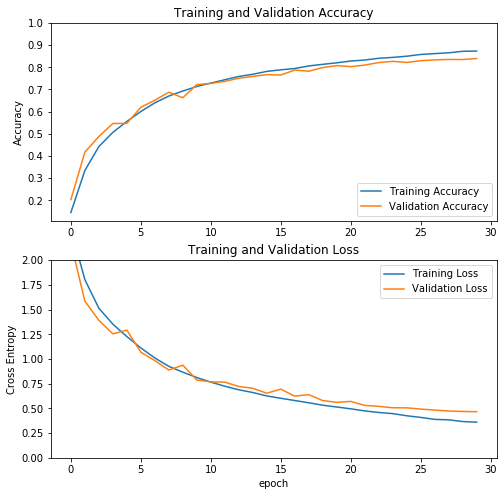

     79/Unknown - 1s 17ms/step - loss: 0.4663 - accuracy: 0.8393Test loss:      0.4662646779531165
Test accuracy:  0.8393


In [8]:
benchmark(resnet, hist, 'resnet_w_bottleneck')

### Potential Improvements
- MobileNet V2 paper suggested that the ReLU activation throws away a lot of information in the bottleneck layer output. Their suggestion, no activation after the bottleneck layer.

## MobileNet V2 Architecture

- [1](https://arxiv.org/pdf/1801.04381.pdf)

- [2](https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5)

__Main Contributions__
- Depthwise Seperable Convolutions - reduce the computational complexity of a standard 2D Conv by replacing this layer with two layers. The first, a __3x3 depthwise convolution__ applying K kernels with each channel (where K is the number of input channels). Second, a __1x1 pointwise convolution__ to produce linear combinations of channel pixels.

- Linear Bottlenecks - TLDR when you are compressing your representation with a convolutional operation, do not use a nonlinearity after the compression. (especially ReLU which throws out negative activations) Instead, make bottleneck layers linear operations.

- Inverted Residuals

In [9]:
def mobilenet_v2_tail(inputs, dims):
    return Conv2D(dims, (3,3), **conv_params)(inputs)

def inverted_residual(inputs, squeeze_dims, expand_ratio=4, downsample=False):
    """
    inputs: Tensor- input to the first layer
    squeeze_dims: int - depth of the channel dimension after squeeze
    expand_ratio: float - multiplier to expand channel dimenions after bottleneck
    downsample: bool - whether to downsample the image
    
    Inverted residual a la MobileNet V2 note the channel dimension will
     be expanded by pointwise conv, processed with depthwise conv, then 
     compressed by a linear bottleneck
    """
    
    expand_dims = int(squeeze_dims * expand_ratio)
    if downsample:
        strides =(2,2)
    else:
        strides=(1,1)
                
    #RESIDUAL PATH (EXPAND - > COMPRESS)
    x = Conv2D(expand_dims, (1, 1), strides=strides, **conv_params)(inputs) #expansion (linear comb across channels)
    x = BatchNormalization(**bn_params)(x)
    x = ReLU(max_value=6)(x)  # the paper uses ReLU6, a thresholded ReLU (3-bit output)

    x = DepthwiseConv2D((3,3), strides=(1,1), **conv_params)(x) #depthwise conv (for spatial data)
    x = BatchNormalization(**bn_params)(x)
    x = ReLU(max_value=6)(x)
    
    x = Conv2D(squeeze_dims, (1, 1), strides=(1, 1), **conv_params)(x) #bottleneck layer
    x = BatchNormalization(**bn_params)(x) #No activation here (Linear BottleNeck)
    
    #IDENTITY PATH
    if downsample: # maintain dimensions during downsampling
        inputs = Conv2D(squeeze_dims, (1, 1), strides=strides, padding='same')(inputs)
    
    #COMBINE
    return Add()([x, inputs])

def mobilenet_v2_head(inputs, dims=None):
    x = Conv2D(dims, (1, 1), strides=(1,1), padding='same')(inputs)
    x = GlobalAveragePooling2D()(x)
    return Dense(DATA_NUM_CLASSES, activation='softmax')(x)

In [10]:
mobilenet_v2 = VGG_Like_CNN(mobilenet_v2_tail,
            inverted_residual,
            mobilenet_v2_head,
            input_shape = (DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS),
            num_levels= 3,
            block_repeats=BLOCK_REPEATS)

mobilenet_v2.compile(optimizer = tf.keras.optimizers.Adam(TRAINING_LR_MAX),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [11]:
hist = train(mobilenet_v2, 'mobilenet_v2')

######################################################
mobilenet_v2
######################################################


Training model mobilenet_v2...
INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


INFO:tensorflow:Assets written to: F://Models/Model_Design/mobilenet_v2/assets


Training complete.


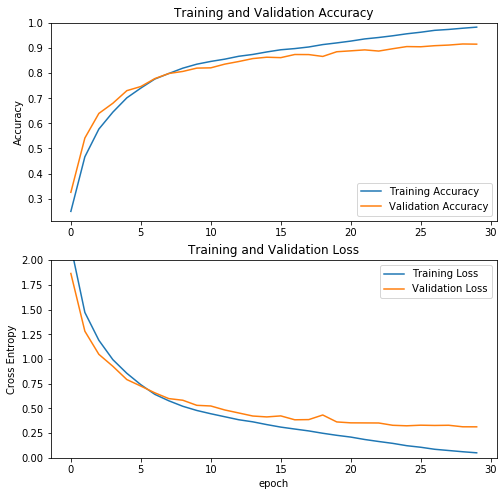

     79/Unknown - 3s 44ms/step - loss: 0.3133 - accuracy: 0.9154Test loss:      0.3132816130601907
Test accuracy:  0.9154


In [12]:
benchmark(mobilenet_v2, hist, 'mobilenet_v2')

## how do you save a Keras History object?

## ResNeXT Architecture

### Sources
- [1](https://arxiv.org/pdf/1611.05431.pdf)


*. Our network is constructed
by repeating a building block that aggregates a set of transformations with the same topology. Our simple design results in a homogeneous, multi-branch architecture that has
only a few hyper-parameters to set. This strategy exposes a
new dimension, which we call “cardinality” (the size of the
set of transformations), as an essential factor in addition to
the dimensions of depth and width*

*In this paper, we present a simple architecture which
adopts VGG/ResNets’ strategy of repeating layers, while
exploiting the split-transform-merge strategy in an easy, extensible way. A module in our network performs a set
of transformations, each on a low-dimensional embedding,
whose outputs are aggregated by summation. We pursuit a
simple realization of this idea — the transformations to be
aggregated are all of the same topology (e.g., Fig. 1 (right)).
This design allows us to extend to any large number of
transformations without specialized designs*


In [13]:
#Xception Implementation  https://arxiv.org/abs/1610.02357

In [14]:
#MobileNetV3 Implementation  https://arxiv.org/abs/1905.02244v5

In [15]:
#Inception V4 Implementation  https://arxiv.org/abs/1602.07261

In [16]:
#NASNet Implementation  https://arxiv.org/abs/1707.07012

In [17]:
#MnasNet Implementation  https://arxiv.org/abs/1807.11626

In [18]:
#AmoebaNet Implementation  https://arxiv.org/abs/1802.01548

In [19]:
#Squeeze and Excite Implementation   https://arxiv.org/abs/1709.01507

In [20]:
#ShuffleNet V2 Implementation  https://arxiv.org/abs/1707.01083

In [21]:
#EfficientNet Implementation https://arxiv.org/abs/1905.11946v3

# Awesome Papers

## ImageNet

https://paperswithcode.com/paper/self-training-with-noisy-student-improves

https://paperswithcode.com/paper/large-scale-learning-of-general-visual

https://paperswithcode.com/paper/fixing-the-train-test-resolution-discrepancy

https://paperswithcode.com/paper/exploring-the-limits-of-weakly-supervised

https://paperswithcode.com/paper/gpipe-efficient-training-of-giant-neural

https://paperswithcode.com/paper/compounding-the-performance-improvements-of

https://paperswithcode.com/paper/billion-scale-semi-supervised-learning-for

https://paperswithcode.com/paper/randaugment-practical-data-augmentation-with

https://paperswithcode.com/paper/adversarial-examples-improve-image

https://paperswithcode.com/paper/multigrain-a-unified-image-embedding-for

https://paperswithcode.com/paper/drop-an-octave-reducing-spatial-redundancy-in

https://paperswithcode.com/paper/harmonic-convolutional-networks-based-on

https://paperswithcode.com/paper/selective-kernel-networks

https://paperswithcode.com/paper/ghostnet-more-features-from-cheap-operations

https://paperswithcode.com/paper/shufflenet-v2-practical-guidelines-for

https://paperswithcode.com/paper/searching-for-mobilenetv3

https://paperswithcode.com/paper/whats-hidden-in-a-randomly-weighted-neural

https://paperswithcode.com/paper/xception-deep-learning-with-depthwise

https://paperswithcode.com/paper/polynet-a-pursuit-of-structural-diversity-in


## MNIST

https://paperswithcode.com/paper/a-branching-and-merging-convolutional-network

https://paperswithcode.com/paper/stochastic-optimization-of-plain



## CIFAR -10


https://paperswithcode.com/paper/large-scale-learning-of-general-visual

https://paperswithcode.com/paper/gpipe-efficient-training-of-giant-neural

https://paperswithcode.com/paper/efficientnet-rethinking-model-scaling-for

https://paperswithcode.com/paper/understanding-and-enhancing-mixed-sample-data

https://paperswithcode.com/paper/large-scale-learning-of-general-visual

https://paperswithcode.com/paper/fast-autoaugment

https://paperswithcode.com/paper/enaet-self-trained-ensemble-autoencoding

https://paperswithcode.com/paper/proxylessnas-direct-neural-architecture

https://paperswithcode.com/paper/squeeze-and-excitation-networks

https://paperswithcode.com/paper/proxylessnas-direct-neural-architecture

https://paperswithcode.com/paper/squeeze-and-excitation-networks

https://paperswithcode.com/paper/fixup-initialization-residual-learning

https://paperswithcode.com/paper/batchboost-regularization-for-stabilizing

https://paperswithcode.com/paper/learning-implicitly-recurrent-cnns-through

https://paperswithcode.com/paper/manifold-mixup-better-representations-by

https://paperswithcode.com/paper/mixup-beyond-empirical-risk-minimization

https://paperswithcode.com/paper/averaging-weights-leads-to-wider-optima-and

https://paperswithcode.com/paper/deep-pyramidal-residual-networks


## CIFAR 100

https://paperswithcode.com/paper/cutmix-regularization-strategy-to-train

https://paperswithcode.com/paper/fast-autoaugment

https://paperswithcode.com/paper/understanding-and-enhancing-mixed-sample-data

https://paperswithcode.com/paper/res2net-a-new-multi-scale-backbone

https://paperswithcode.com/paper/enaet-self-trained-ensemble-autoencoding

https://paperswithcode.com/paper/single-bit-per-weight-deep-convolutional

https://paperswithcode.com/paper/towards-principled-design-of-deep

https://paperswithcode.com/paper/training-neural-networks-with-local-error